In [1]:
import torch
from data_logger import DataLogger
from dqn_agent import Agent
from utils import *
from tqdm import tqdm
print(torch.cuda.is_available())

True


In [2]:
#Loading parameters
ep, lp, hp = get_params() #params["environment"], params["logging"], params["hyperparameters"]
hp_algo = hp['dqn/ddqn']

In [3]:
env = get_env(game=ep["game"], level=ep["level"], action_space=ep["action_space"])
env = apply_wrappers(env, skip=ep["skip"], gray_scale=ep["gray_scale"], shape=ep["frame_shape"], num_stack=ep["num_stack"], library=hp_algo["library"])
next_state = env.reset()
print(next_state.shape)

(4, 84, 84)


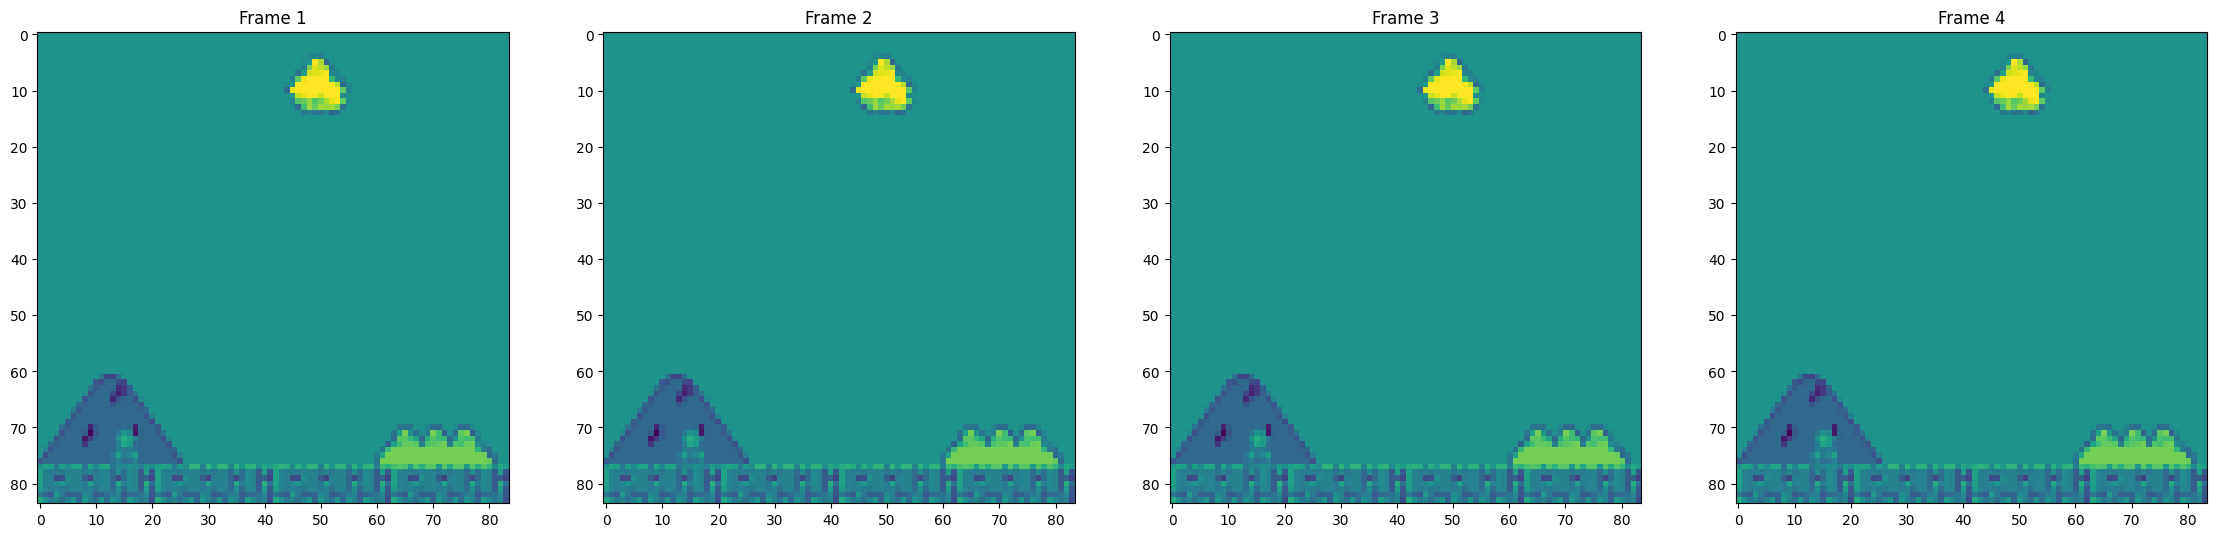

In [4]:
#from utils import *
next_state, reward, done, info = env.step(get_action_sample(env))
plot_sequence_observations(next_state)

In [5]:
agent = Agent(env, batch_size=hp_algo["batch_size"], time_steps=hp_algo["time_steps"], buffer_size=hp_algo["buffer_size"], learning_rate=hp_algo["learning_rate"], observation_size=(ep["num_stack"],)+tuple(ep["frame_shape"]), action_size=get_action_space_size(env), 
              discount_factor=hp_algo["discount_factor"], model=hp_algo["model"], epsilon_min=hp_algo["exploration_final_eps"], exploration_fraction=hp_algo["exploration_fraction"], update_online_every=hp_algo["train_freq"],
              update_target_from_online_every=hp_algo["target_update_interval"], start_learning_after=hp_algo["learning_starts"])
logger = DataLogger(env, hp, agent, model=hp_algo["model"])

while logger.time_step_count < hp_algo["time_steps"]:
    state = env.reset()
    while True:
        #print(state)
        action_idx = agent.act(state)

        next_state, reward, done, info = env.step(get_action(action_idx, env))

        agent.append_experience_to_memory(state, next_state, action_idx, reward, done)
        
        loss = agent.learn()

        state = next_state

        env.render()

        logger.time_step(reward, loss, n_time_steps_save_model=lp["n_time_steps_save_model"])

        if done or info["flag_get"]:
            break

    logger.episode_step(info)

logger.close()

Model saved to logs\SuperMarioBros-1-1-v0\DDQN\20240131174224\checkpoints\0.pth at step 0
Best model saved to logs\SuperMarioBros-1-1-v0\DDQN\20240131174224\checkpoints\best_model.pth at episode 1
Best model saved to logs\SuperMarioBros-1-1-v0\DDQN\20240131174224\checkpoints\best_model.pth at episode 2


KeyboardInterrupt: 

In [ ]:
env.close()

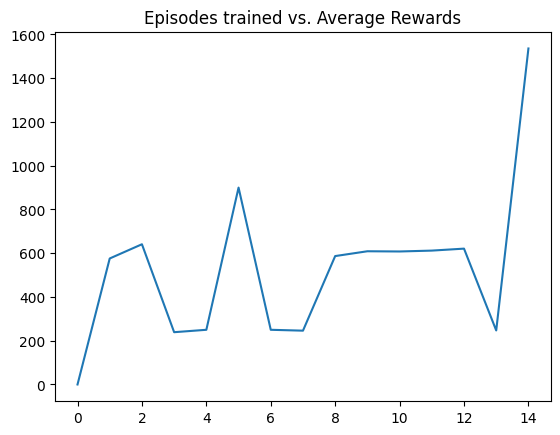

In [6]:
import pickle
with open(r"logs\SuperMarioBros-1-1-v0\DDQN\20240131132219\train\total_rewards", 'rb') as f:
    rews = pickle.load(f)
plot_average_reward(rews, title="Episodes trained vs. Average Rewards", n_average=1)

In [ ]:
#Testing trained model
env = get_env(game=ep["game"], level=ep["level"], action_space=ep["action_space"])
env = apply_wrappers(env, skip=ep["skip"], gray_scale=ep["gray_scale"], shape=ep["frame_shape"], num_stack=ep["num_stack"], buffer=ep["buffer"])

agent = Agent(env, batch_size=hp_algo["batch_size"], buffer_size=hp_algo["buffer_size"], learning_rate=hp_algo["learning_rate"], observation_size=(ep["num_stack"],)+tuple(ep["frame_shape"]), action_size=get_action_space_size(env), 
              discount_factor=hp_algo["discount_factor"], model=hp_algo["model"], epsilon_min=hp_algo["exploration_min"], epsilon_decay=hp_algo["exploration_decay"], update_online_every=hp_algo["train_freq"],
              update_target_from_online_every=hp_algo["target_update_interval"], start_learning_after=hp_algo["learning_starts"])
agent.load(r"logs\SuperMarioBros-1-1-v0\DDQN\20240129231225\checkpoints\best_model.pth")

Loading model at logs\SuperMarioBros-1-1-v0\DDQN\20240129231225\checkpoints\best_model.pth with exploration rate 0.02


In [ ]:
try:
    while True:
        time_stamp=0
        state = env.reset()
        while time_stamp<1e4:
            action_idx = agent.act(state)

            next_state, reward, done, info = env.step(get_action(action_idx, env))

            state = next_state

            env.render()
            
            time_stamp += 1

            if done or info["flag_get"]:
                break
except:
    env.close()